# Imported accesories

In [1]:
import numpy as np
from vector_class import TripleVector
import matplotlib.pyplot as plt
import random
import sys
from numpy import random



# Parameters

In [121]:
A0 = 1e10 # Bq
Ab = 500 # Bq
h = 10 # m
D_t = 100 # the pause on each point od the grid in s
x_max = 4 # m
y_max = 4 # m
grid = [8, 8] # m
n_bins = 20

radiation = [A0, Ab, D_t]
detector = [h, x_max, y_max, grid]



# Code

## Flying over the surface

In [122]:
def I(A0, r, D_t, rk=1):
    return (rk**2 / (r + rk)**2) * A0*D_t

def r(A0, I, D_t, rk=1):
    return rk*(np.sqrt((A0*D_t / I)) - 1)

def point_source(x_max, y_max):
    return [random.uniform(-x_max, x_max),random.uniform(-y_max, y_max)]

def flyOver(radiation, detector, source = []): # grid is a list which tells the number of tiles for x and y
    A0, Ab, D_t = radiation[0], radiation[1], radiation[2]
    h, x_max, y_max, grid = detector[0], detector[1], detector[2], detector[3]
    N_x, N_y = grid[0], grid[1]
    square_x, square_y = (2*x_max)/N_x, (2*y_max)/N_y 
    xes = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_x))
    if len(source) == 0:
        source = point_source(x_max, y_max)
    intensities = np.zeros((int(N_x), int(N_y)))
    intensities_list = []
    grid_x, grid_y = np.zeros((int(N_x), int(N_y))), np.zeros((int(N_x), int(N_y)))
    n, m = N_x - 1, 0
    y = -y_max + square_y/2
    i = 1
    max_intensity = {"number": [0], "postion": [[(0, 0), (0, 0)]]}
    for x in xes:
        while abs(y) <= y_max:
            drone = TripleVector(x, y, h)
            position = TripleVector(source[0], source[1], 0)
            r_vector = drone - position
            r = r_vector.magnitude()
            intensity = I(A0, r, D_t)
            if Ab*D_t > intensity:
                intensities[n, m] = 0
            else:
                intensities[n, m] = intensity - Ab*D_t
                intensities_list.append(intensity - Ab*D_t)
            grid_x[n, m], grid_y[n, m] = x, y
            if max_intensity["number"][0] < intensity:
                max_intensity["number"], max_intensity["position"] = [intensity], [[(x - square_x/2, x + square_x/2), (y - square_y/2, y + square_y/2)]]
            elif max_intensity["number"][0] == intensity:
                max_intensity["position"] = [max_intensity["position"][0], [(x - square_x/2, x + square_x/2), (y - square_y/2, y + square_y/2)]]
            y += (square_y)*i
            n -= 1*i
        n += 1*i
        i = i * (-1)
        y += (square_y)*i
        m += 1

    return {"intensities_array": intensities, "source": source, "intensities_list": intensities_list, "grid_x": grid_x, "grid_y": grid_y, "hotspot": max_intensity["position"], "square_x": square_x, "square_y": square_y}

#  A0, Ab, D_t, h, x_max, y_max, square
measurement = flyOver(radiation, detector)



## Location from measurement

In [123]:
def circle_center(x, y, w=[]):
    A = np.array([x, y, np.ones(len(x))]).T
    b = x**2 + y**2
    
    # Modify A,b for weighted least squares
    if len(w) == len(x):
        W = np.diag(w)
        A = np.dot(W,A)
        b = np.dot(W,b)
    
    # Solve by method of least squares
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    S = np.linalg.lstsq(A, b, rcond=None)[1]
    
    # Get circle parameters from solution c
    xc = c[0]/2
    yc = c[1]/2
    r = np.sqrt(c[2] + xc**2 + yc**2)
    return {"parameters": [xc, yc, r], "sum_residuals": S}


def find_source(measurement, radiation, n_bins):
    A0, Ab, D_t = radiation[0], radiation[1], radiation[2]
    square_x = measurement["square_x"]
    square_y = measurement["square_y"]
    edge2, edge1 = np.max(measurement["intensities_array"]), np.min(measurement["intensities_array"])
    
    ran = np.linspace(edge1, edge2, n_bins)
    histogram = np.histogram(measurement["intensities_list"], ran) # here the list of intensities becomes useful
    if max(histogram[0]) <= 2:
        sys.exit("Error to many bins - all of them contain less than three points. Reduce the number n_bins!")
    candidates, outsiders= np.zeros((1, 2)), np.zeros((1, 2))
    var_can, var_out = [], []
    borders = measurement["hotspot"]
    for fit_points in histogram[0]:
        if fit_points > 2:
            i = list(histogram[0]).index(fit_points)
            Range = histogram[1][i:(i+2)]
            dr = np.abs(r(A0, Range[1], D_t) - r(A0, Range[0], D_t))
            n, m = measurement["intensities_array"].shape
            X, Y = [], []
            for i in range(n):
                for j in range(m):
                    if (Range[0] <= measurement["intensities_array"][i, j] and measurement["intensities_array"][i, j] <= Range[1]):
                        X.append(measurement["grid_x"][i, j])
                        Y.append(measurement["grid_y"][i, j])
            points = [np.array(X), np.array(Y)]
            circle = circle_center(points[0], points[1])
            circle_values = circle["parameters"]
            S = circle["sum_residuals"]
            X_c, Y_c = circle_values[0], circle_values[1]
            n, m = len(points[0]), 3
            if len(S) != 0:
                variance = (S[0]/(n - m))*dr**2
            else:
                variance = 0
            for border in borders: # eliminate the circle centres that are out of the tile "hotspots"
                if (border[0][0] <= X_c and X_c <= border[0][1]) and (border[1][0] <= Y_c and Y_c <= border[1][1]):
                    candidates = np.vstack((candidates, np.array([X_c, Y_c])))
                    var_can.append(variance)
                else:
                    outsiders = np.vstack((outsiders, np.array([X_c, Y_c])))
                    var_out.append(variance)

    border = borders[0]
    while len(candidates[1:, :]) == 0:
        border = [(border[0][0] - square_x, border[0][1] + square_x), (border[1][0] - square_y, border[1][1] + square_y)]
        for i in range(len(outsiders[1:, :])):
            X_c, Y_c = outsiders[i, 0], outsiders[i, 1]
            if (border[0][0] <= X_c and X_c <= border[0][1]) and (border[1][0] <= Y_c and Y_c <= border[1][1]):
                candidates = np.vstack((candidates, np.array([X_c, Y_c])))
                var_can.append(var_out[i])

    # print(candidates[1:, :])
    # print(var_can)
    # print(sum(list(var_can))/len(var_can))

    return {"point_candidates": candidates[1:, :], "average_point": candidates[1:, :].mean(axis=0), "variance": (sum(list(var_can))/len(var_can))}

points = find_source(measurement, radiation, 40)

# print(np.sqrt(points["variance"]))

# print(elimination(np.array([[ 0,  1],
#        [-0.5, 1.0],
#        [10, 11],
#        [15, 16]]), [[(-2.0, 2.0), (-3.0, 3.0)]]))



In [5]:
x = np.array([0, 1, 2, 3])
y = np.array([-1, 0.2, 0.9, 2.1])

A = np.vstack([x, np.ones(len(x))]).T

m, c = np.linalg.lstsq(A, y, rcond=None)[0]

print(np.linalg.lstsq(A, y, rcond=None))



(array([ 1.  , -0.95]), array([0.05]), 2, array([4.10003045, 1.09075677]))


## Combine the measurement and location of the source

In [124]:
def dist_points(point1, point2):
    return (point1 - point2).magnitude()

def combination(radiation, detector, n_bins, source = []):
    measurement = flyOver(radiation, detector, source)
    points = find_source(measurement, radiation, n_bins)
    #dr = dist_points(TripleVector(measurement[1][0], measurement[1][1], 0), TripleVector(circle_values[0], circle_values[1], 0))
    # hotspot_tile = measurement["hotspot"]
    return {"measurement": measurement, "x_max": x_max, "y_max": y_max, "find_source": points, "standard_deviation": np.sqrt(points["variance"])} # , hotspot_tile]#, dr]



## Visualization

<ipython-input-147-95685ff18d54>:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


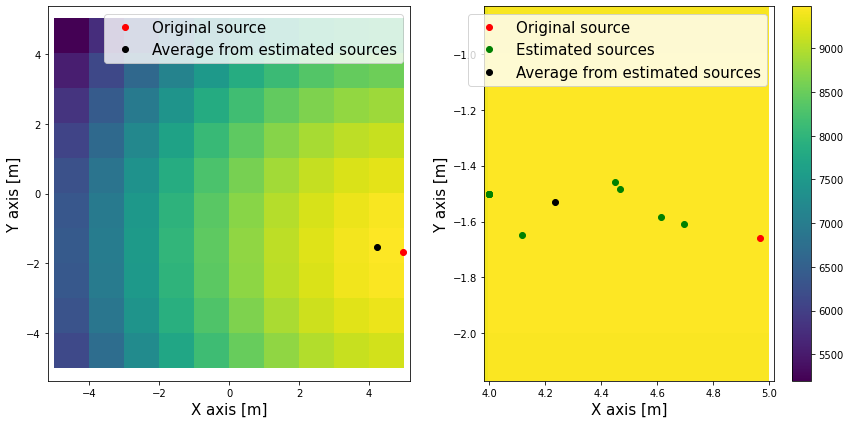

In [147]:
# COMMENT: Purple tiles are the ones where the signal is so weak that you cannot distiguish it from the background radiation

def visualize(measurement, x_max, y_max, points):

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    
    im = ax1.imshow(measurement["intensities_array"], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    X, Y = measurement["source"][0], measurement["source"][1]
    ax1.plot(X, Y, "o", color = 'r', label = "Original source")
    ax1.plot(points["average_point"][0], points["average_point"][1], "o", color = 'k', label = "Average from estimated sources")
    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)

    plt.colorbar(im)
   
    ax1.legend(fontsize = 15)
    #plt.grid()

    ax2.imshow(measurement["intensities_array"], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    X, Y = measurement["source"][0], measurement["source"][1]
    ax2.plot(X, Y, "o", color = 'r', label = "Original source")
    ax2.plot(points["point_candidates"][:, 0], points["point_candidates"][:, 1], "o", color = 'g', label = "Estimated sources")
    ax2.plot(points["average_point"][0], points["average_point"][1], "o", color = 'k', label = "Average from estimated sources")
    ax2.axis("equal")
    ax2.set_xlim(measurement["hotspot"][0][0][0], measurement["hotspot"][0][0][1])
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylim(measurement["hotspot"][0][1][0], measurement["hotspot"][0][1][1])
    ax2.set_ylabel("Y axis [m]", fontsize = 15)

   
    ax2.legend(fontsize = 15)
    #plt.grid()
    

    plt.tight_layout()
    # plt.savefig("graphics/imporved.jpg")
    plt.show()
    # return points[1]


data = combination(radiation, detector, n_bins)

visualize(data["measurement"], data["x_max"], data["y_max"], data["find_source"])

# print(data[0][1])
# print(data[4])
# data["find_source"]["average_point"][0]



## Error calculation

### Standard deviation from multiple simulations

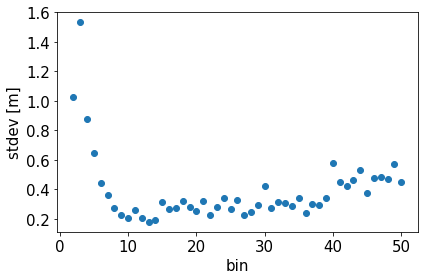

13

In [8]:
def dist_points(point1, point2):
    return (point1 - point2).magnitude()

# run simulation n_sim times and keep track of the distance between the original source and estimated source. Plot a histogram for the values.
def stdDev(radiation, detector, n_bins, n_sim):
    R = []
    for i in range(n_sim):
        data = combination(radiation, detector, n_bins)
        original = (data["measurement"])["source"]
        estimate = (data["find_source"])["average_point"]
        R.append(dist_points(TripleVector(original[0], original[1], 0), TripleVector(estimate[0], estimate[1], 0)))
 
    # plt.hist(np.array(R), 100)
    # plt.xlabel("r error [m]", fontsize = 15)
    # plt.xticks(fontsize = 15)
    # plt.ylabel("number of values", fontsize = 15)
    # plt.yticks(fontsize = 15)

    # #plt.legend(fontsize = 15)
    # #plt.grid()

    # plt.tight_layout()
    # # plt.savefig("graphics/dr_hist.jpg")
    # plt.show()

    d_R = np.std(R)

    return d_R

# standar deviation in relation to number of bins used to define the measured intesities histogram
def stdDev_to_nBins(radiation, detector, n_bins, n_sim, RangeBins):
    min = 0
    MyList = []
    for bin in RangeBins:
        std = stdDev(radiation, detector, int(bin), n_sim)
        MyList.append(std)
        if min == 0:
            min = [bin, std]
        elif std < min[-1]:
            min = [bin, std]

    plt.plot(RangeBins, MyList, "o")
    plt.xlabel("bin", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylabel("stdev [m]", fontsize = 15)
    plt.yticks(fontsize = 15)

    #plt.legend(fontsize = 15)
    #plt.grid()

    plt.tight_layout()
    #plt.savefig("")
    plt.show()

    return int(min[0])

# stdDev(radiation, detector, n_bins, 100)
stdDev_to_nBins(radiation, detector, n_bins, 100, [int(n) for n in np.linspace(2, 50, 49)])


### Calculated standard deviation (room for improvement)(?)

In [13]:
# Comparison between the measured and calculated standard deviation
def MeaCalComp(radiation, detector, n_sim):
    dr_sim = []
    dr_cal = []
    I = []
    for i in range(100):
        dr_sim.append(stdDev(radiation, detector, n_bins, n_sim))
        dr_cal.append(combination(radiation, detector, n_bins)["standard_deviation"])
        I.append(i)
    plt.plot(np.array(I), np.array(dr_sim), "o", color = "k", label = "From simulations")
    plt.plot(np.array(I), np.array(dr_cal), "o", color = "b", label = "From calculations")
    plt.xlabel("n of simulation", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylabel("stdev [m]", fontsize = 15)
    plt.yticks(fontsize = 15)

    plt.legend(fontsize = 15)
    #plt.grid()

    plt.tight_layout()
    #plt.savefig("")
    plt.show()
        
# MeaCalComp(radiation, detector, 100)

# We can se that the calculated data is all over the place for multiple randomlly generated points odurces. In comparison the data from the 
# simluated standar deviations devates a little but is much more stabel. I am guessing that there is a mistake in the process of calculation. 
# I am not sure if I understand the covariance matrix correctly, further work needed here.


## Analysis

### Deviation compared to position of source

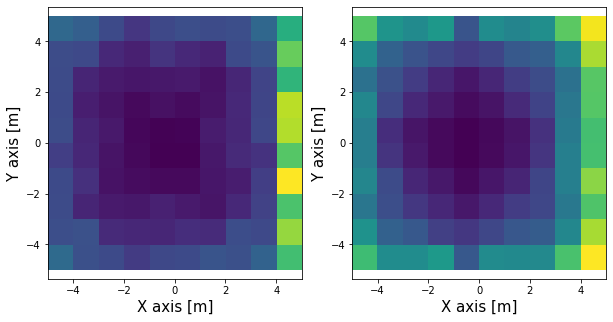

In [43]:
# graf to show how the deviation is affected for different positions of the source

# the code will go over every tile but will choose a random position within that tile
def DevCompPos(radiation, detector, n_bins, K):    
    x_max, y_max, grid = detector[1], detector[2], detector[3]
    N_x, N_y = grid[0], grid[1]
    square_x, square_y = (2*x_max)/N_x, (2*y_max)/N_y 
    xes = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_x))
    yes = np.linspace(-y_max + square_y/2, y_max + square_y/2, int(N_y))
    MyArrMes = np.ones((N_x, N_y))
    MyArrCal = np.ones((N_x, N_y))
    for k in range(K): # run every K-times to average
        for i in range(N_x):
            for j in range(N_y):
                source = [random.uniform(xes[i] - square_x/2, xes[i] + square_x/2), random.uniform(yes[j] - square_y/2, yes[j] + square_y/2)]
                data = combination(radiation, detector, n_bins, source)
                estimation = TripleVector((data["find_source"])["average_point"][0], (data["find_source"])["average_point"][1], 0)
                original = TripleVector(source[0], source[1], 0)
                dr = dist_points(estimation, original)
                MyArrMes[i, j] = (k/(k+1))*MyArrMes[i, j] + (dr/(k+1))
                MyArrCal[i, j] = (k/(k+1))*MyArrCal[i, j] + (data["standard_deviation"]/(k+1))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))

    ax1.imshow(MyArrMes, extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # X, Y = measurement["source"][0], measurement["source"][1]
    # plt.plot(X, Y, "o", color = 'r', label = "Original source")
    # plt.plot(points["average_point"][0], points["average_point"][1], "o", color = 'k', label = "Average from estimated sources")
    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)

    ax2.imshow(MyArrCal, extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # X, Y = measurement["source"][0], measurement["source"][1]
    # plt.plot(X, Y, "o", color = 'r', label = "Original source")
    # plt.plot(points["average_point"][0], points["average_point"][1], "o", color = 'k', label = "Average from estimated sources")
    ax2.axis("equal")
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylabel("Y axis [m]", fontsize = 15)

# Shows grid same as in Visualization, but here the coloration on a certain tile shows the deciation when the source is located in that 
# tile
K = 100
DevCompPos(radiation, detector, n_bins, K)


### Height changes

[40.  40.8 41.6 42.4 43.2 44. ]


<ipython-input-132-dc4ca960a90c>:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im1)


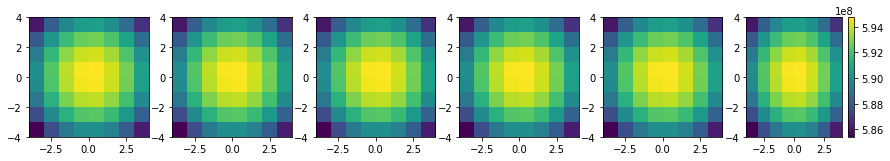

In [132]:
# Source and height range
source = [0.15, 0.12]
heightRange = np.linspace(40, 44, 6)

def hToGridVisualization(radiation, detector, source, heightRange):
    MyList = []
    x_max, y_max = detector[1], detector[2]
    for height in heightRange:
        detector[0] = height
        data = flyOver(radiation, detector, source)
        MyList.append(data["intensities_array"])
    
    print(heightRange)

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 2.2))

    im1 = ax1.imshow(MyList[0], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    im2 = ax2.imshow(MyList[1], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    im3 = ax3.imshow(MyList[2], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    im4 = ax4.imshow(MyList[3], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    im5 = ax5.imshow(MyList[4], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    im6 = ax6.imshow(MyList[5], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    plt.colorbar(im1)
    # plt.colorbar(im2)
    # plt.colorbar(im3)
    # plt.colorbar(im4)
    # plt.colorbar(im5)
    # plt.colorbar(im6)
    
hToGridVisualization(radiation, detector, source, heightRange)


### Deviation compared to height

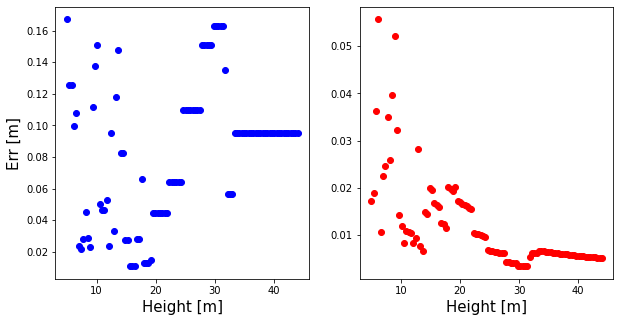

In [140]:
# Constant position of the source somerwhere close to the center of the grid
source = [0.15, 0.12]
# The range at which the height is changed
heightRange = np.linspace(5, 44, 100)

#Changing the hight of the detector flight and seeing how it affects the error
def ChangeHeight(radiation, detector, n_bins, source, heightRange):
    MyListMea, MyListCal = [], []
    for height in heightRange:
        detector[0] = height
        data = combination(radiation, detector, n_bins, source)
        estimation = TripleVector((data["find_source"])["average_point"][0], (data["find_source"])["average_point"][1], 0)
        original = TripleVector(source[0], source[1], 0)
        dr = dist_points(estimation, original)
        MyListMea.append(dr)
        MyListCal.append(data["standard_deviation"])

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))#, sharey = True)

    ax1.plot(heightRange, np.array(MyListMea), "o", color="b", label = "Measured")
    ax1.set_xlabel("Height [m]", fontsize = 15)
    ax1.set_ylabel("Err [m]", fontsize = 15)
    
    ax2.plot(heightRange, np.array(MyListCal), "o", color="r", label = "Calculated")
    # ax2.axis("equal")
    ax2.set_xlabel("Height [m]", fontsize = 15)
    # ax2.set_ylabel("Err [m]", fontsize = 15)
    


ChangeHeight(radiation, detector, n_bins, source, heightRange)


# Describtion of the code

<ipython-input-147-95685ff18d54>:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


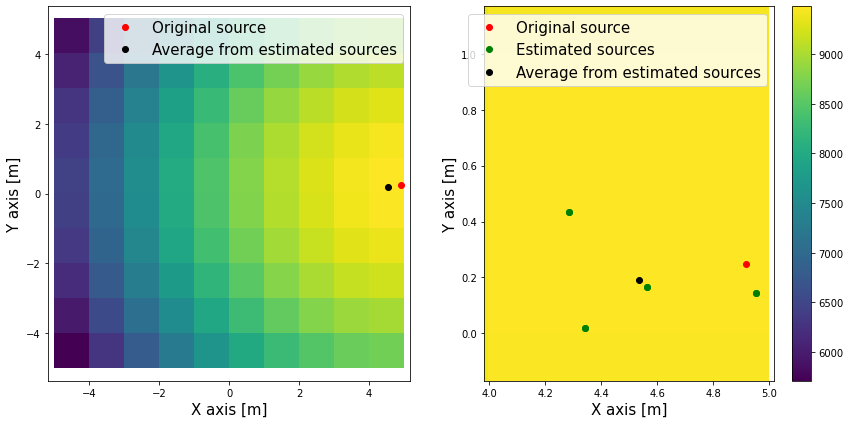

3.082301440375097


In [148]:
# DESCRIPTION OF THE CODE
# 1) flyOver() generates a single point source randomly somwhere on the grid specified by x_max and y_max (if we do not specify a specific 
# position). The grid is also divided into tiles by the argument grid. The detector "flys over" at the hieght h starting in the bottom left 
# tile and moving upward. When it reaches the upper left tile it moves right for one tile and goes down. This continues for the entire grid.
# At each point the detector stops in the center of the tile for D_t and measures the intensity at that tile. This is estimated using the
# inverse square law, defined with the function I(). flyover() returns a dictionary in which the first value is a n x m array, where n and m
# are the respective values in grid. Each entry in the array contains the intensity which coresponds to the measurement in the tile which has
# the position [n, m]. The second dictionary value in the list is the position of the randomly generated point source. The third value is a list
# of intensities, which will be useful in further code. The last two values each contain an array of the same dimentions as the one in the first
# key of the dictionary. The first one contains the x coordinates of the cenetr of tiles and the second one contains the same data just for the
# y coodidinates.

# 2) find_Source() uses the data made by flyOver() to estimate the position of the point source. Beside that it takes one more parameter, n_bins. 
# this is the number of bins that will be used in a histogram made with the list of intensities measured with the detector fly-by. Using the 
# histogram we can group the intesities which are closely together according to the values. For all of the intensities that fall in the same
# bin we gather the point position of the detector. These points must lie on the same circle. We use the the numpay least square method to find 
# the center of such a circle. This proces is repeated for all of the bins that contain at least three intensities. The possible centers of 
# circles are then examined further. The ones which are located outside of the tile which has the largest intesity value ("hotspot" tile) are 
# disqualified, but if none of the points are in the "hotspot" tile the acceptable area is gradualy increased from the original size until at
# at least one point is obtained. From this we then calculate the average position and this is the estimated point source position. The function
# returns an N x 2 array which contains the points which are averaged and an array which returns the calculated avarage point.

# 3) combination() is just some sunsidary function that combines 1) and 2) in one command. It also returns out the deviation for the estimated 
# point position.

# 4) visualize() uses matplotlib to produce two plots. The one on top shows the input grid where each tile is colored acoording to the
# intensity, which was measured there. It also plots the positon of the randomly generated point source (red dot) and the estimated point 
# source (black dot). However the bottom plot shows only the "hitspot tile". It shows the same points as the first plot, but on top of that 
# also all the center circle points (green dots) which are averaged to get the final sorc position.

# 5) The error calculations subtitle contains different functions which I am still working on to determine the error of the estimated point 
# source.

# 4) The analysis substitle contains all of the analysis of the code
# 4.1) DevCompPos() simulates the source at each tile multiple times and then avereges the calculated deviation and the measured distance
# between the original source ant the estimate. The results are displayed in the form of a grid where each tile is colored according to the
# deviation for when the source is somwhere inside that tile. We can see that the deviation is not independent of the position of the point
# source. The ones on the borders have a larger uncertianty. The dependancy on the point position is also more indepentednt for the calculated
# data (?)

# PARAMETERS
A0 = 1e6 # activity of the source in Bq
Ab = 500 # background activity in Bq
h = 40 # hight at which the detector flies over in m
x_max = 5 # Size of the area of flyover in x direction in m
y_max = 5 # Size of the area of flyover in y direction in m
grid = [10, 10] # Size of the grid in which the area of flyover is divided into smaller "tiles" where the detector stops and measures the
                # number of radioactive decays. The first number is the number of these areas in x direction and the second is the number in y
                # direction, components must be INTEGERS!
D_t = 100 # the pause on each point od the grid in s
n_bins = 20 # number of bins in the histogram made by find_source()

# Combinig the parameters into a list so that the data is more compacted
radiation = [A0, Ab, D_t]
detector = [h, x_max, y_max, grid]

data = combination(radiation, detector, n_bins)

visualize(data["measurement"], data["x_max"], data["y_max"], data["find_source"])

print(data["standard_deviation"])


In [35]:
MyList = [[-0.8255814, -4.89534884],
 [-0.8255814, -4.89534884],
 [-0.8255814, -4.89534884],
 [-0.6352413, -4.91358025],
 [-0.6352413, -4.91358025],
 [-0.6352413, -4.91358025]]

result = [-0.73041135 -4.90446454]

N, M = len(MyList), len(MyList[1])
X = []
Y = []
for i in range(N):
    for j in range(M):
        if j == 0:
            X.append(MyList[i][j])
        else:
            Y.append(MyList[i][j])

# print(sum(X)/N)
# print(sum(Y)/N)

# print((np.sqrt(2) - 1)/np.sqrt(2))
# print((np.sqrt(3) - np.sqrt(2)/np.sqrt(6)))

a = [15, 16, 13, 12, 14, 15, 12, 17]
b = [15, 16, 13, 12, 14, 15, 12, 17, 14.8]

print(sum(a)/len(a))
print((14.25 + 14.8)/2, "Not correct.")
print(sum(b)/len(b))
print(14.25 * (len(a)/(1 + len(a))) + 14.8/(1 + len(a)), "Is correct")



14.25
14.525 Not correct.
14.311111111111112
14.31111111111111 Is correct
